In [1]:
!pip install vit-keras
!pip install tensorflow-addons
# Loading Drive for Colab
from google.colab import drive
from google.colab import files
import os
import time
import warnings
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, classification_report,
                             cohen_kappa_score, confusion_matrix)
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.layers import (Conv3D, Dense, Dropout, Flatten, Input, Reshape, concatenate)
from tensorflow.keras import regularizers
from tensorflow.keras import layers, Model
from keras.losses import categorical_crossentropy
from keras.models import Model, Sequential
from tensorflow.keras.layers import (Activation, Lambda, multiply)
from tensorflow.keras.optimizers import Adam
from keras.optimizers import Adam
from operator import truediv
from vit_keras import utils, vit
from keras.utils import to_categorical

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.9 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


**Load HSI Datasets**

In [2]:
## Loading Hyperspectral Datasets and Mounting the Colab Drive for Loading Datasets
drive.mount('/content/drive')
## Loading Datasets
def LoadHSIData(method):
    data_path = os.path.join(os.getcwd(),'/content/drive/My Drive/Colab')
    if method == 'PU':
        HSI = sio.loadmat(os.path.join(data_path, 'ColabPaviaU.mat'))['paviaU']
        GT = sio.loadmat(os.path.join(data_path, 'ColabPaviaU_gt.mat'))['paviaU_gt']
        Num_Classes = 9
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted','Soil','Bitumen',
                        'Bricks','Shadows']
    elif method == 'SA':
        HSI = sio.loadmat(os.path.join(data_path, 'ColabSalinas_corrected.mat'))['salinas_corrected']
        GT = sio.loadmat(os.path.join(data_path, 'ColabSalinas_gt.mat'))['salinas_gt']
        Num_Classes = 16
        target_names = ['Weeds_1','Weeds_2','Fallow', 'Fallow_rough_plow',
                        'Fallow_smooth', 'Stubble','Celery', 'Grapes_untrained',
                        'Soil_vinyard_develop','Corn_Weeds', 'Lettuce_4wk',
                        'Lettuce_5wk','Lettuce_6wk', 'Lettuce_7wk',
                        'Vinyard_untrained','Vinyard_trellis']
    elif method == 'UH13':
      HSI = sio.loadmat(os.path.join(data_path, 'ColabHU.mat'))['HSI']
      GT = sio.loadmat(os.path.join(data_path, 'ColabHU_gt.mat'))['gt']
      Num_Classes = 15
      target_names = ['Healthy grass', 'Stressed grass', 'Synthetic grass', 'Trees',
                    'Soil', 'Water', 'Residential', 'Commercial', 'Road',
                    'Highway', 'Railway', 'Parking Lot 1', 'Parking Lot 2',
                    'Tennis Court', 'Running Track']
    return HSI, GT, Num_Classes, target_names

Mounted at /content/drive


**Important Internal Functions**

In [3]:
## Prediction Model
def PreModel(Actual, model):
  ## Validation Prediction Model
  prediction = model.predict(Actual)
  argmax_prediction = np.argmax(prediction, axis=1) + 1  # Add 1 to the argmax result to shift the class labels
  non_zero_classes = np.unique(argmax_prediction)  # Get the unique non-zero class labels
  # Remove the 0 class label if it exists in the non_zero_classes array
  if 0 in non_zero_classes:
    non_zero_classes = non_zero_classes[non_zero_classes != 0]
  # Filter out the non-zero classes from the argmax_prediction array
  Pre = argmax_prediction[np.isin(argmax_prediction, non_zero_classes)]
  return Pre

## Computing the Accuracies and Confusion Matrix for Disjoint Samples
def ClassificationReports(TeC, HSID, Te_Pre, target_names):
  classification = classification_report(np.argmax(TeC, axis=1)+1, Te_Pre, target_names = target_names)
  oa = accuracy_score(np.argmax(TeC, axis=1)+1, Te_Pre)
  oa = round(oa, 4)
  confusion = confusion_matrix(np.argmax(TeC, axis=1)+1, Te_Pre)
  list_diag = np.diag(confusion)
  list_raw_sum = np.sum(confusion, axis=1)
  each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
  aa = np.mean(each_acc)
  aa = round(aa, 4)
  kappa = cohen_kappa_score(np.argmax(TeC, axis=1)+1, Te_Pre)
  kappa = round(kappa, 4)
  return classification, confusion, oa*100, each_acc*100, aa*100, kappa*100

## Writing Results in CSV files
def CSVResults(file_name, Tr_Time, Te_Time, Te_classification,
               Te_Confusion, Te_Kappa, Te_OA, Te_AA, Te_Per_Class):
    Te_classification = str(Te_classification)
    Te_Confusion = str(Te_Confusion)
    with open(file_name, 'w') as CSV_file:
      CSV_file.write('{} Tr_Time'.format(Tr_Time))
      CSV_file.write('\n')
      CSV_file.write('{} Te_Time'.format(Te_Time))
      CSV_file.write('\n')
      CSV_file.write('{} Te Kappa (%)'.format(Te_Kappa))
      CSV_file.write('\n')
      CSV_file.write('{} Te Overall (%)'.format(Te_OA))
      CSV_file.write('\n')
      CSV_file.write('{} Te Average (%)'.format(Te_AA))
      CSV_file.write('\n')
      CSV_file.write('{} Te Classification'.format(Te_classification))
      CSV_file.write('\n')
      CSV_file.write('{} Te Per Class'.format(Te_Per_Class))
      CSV_file.write('\n')
      CSV_file.write('{} Te Confussion'.format(Te_Confusion))
      CSV_file.write('\n')
    return CSV_file

**Initializating Parameters**

In [4]:
## Global Parameters for Loop
HSID = "UH13" ## UH13, PU, SA
WS = 8
teRatio = 0.8
vrRatio = 0.5
k = 15
adam = tf.keras.optimizers.legacy.Adam(lr = 0.0001, decay = 1e-06)
epochs = 50
batch_size = 56

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


**3D Patch Process**

In [5]:
## Creat Patches for 3D (Spatial-Spectral) Models
def ImageCubes(HSI, GT, WS=WS, removeZeroLabels=True):
    num_rows, num_cols, num_bands = HSI.shape
    margin = int(WS / 2)
    padded_data = np.pad(HSI, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    image_cubes = np.zeros((num_rows * num_cols, WS, WS, num_bands))
    patchesLabels = np.zeros((num_rows * num_cols))
    patchIndex = 0
    for r in range(margin, num_rows + margin):
        for c in range(margin, num_cols + margin):
            cube = padded_data[r - margin: r + margin, c - margin: c + margin, :]
            image_cubes[patchIndex, :, :, :] = cube
            patchesLabels[patchIndex] = GT[r-margin, c-margin]
            patchIndex = patchIndex + 1
    return image_cubes, patchesLabels

## Dimensional Reduction (If required)
def DLMethod(HSI, NC = 75):
  RHSI = np.reshape(HSI, (-1, HSI.shape[2]))
  pca = PCA(n_components = NC, whiten = True)
  RHSI = pca.fit_transform(RHSI)
  RHSI = np.reshape(RHSI, (HSI.shape[0], HSI.shape[1], NC))
  return RHSI

**Preprocessing**

In [6]:
## Main Function to load Datasets
HSI, GT, Num_Classes, target_names = LoadHSIData(HSID)
## Reduce the Dimensionality (If required)
start = time.time()
RDHSI = DLMethod(HSI, NC = k)
end = time.time()
DL_Time = end - start
## Create Image Cubes for Model Building
CRDHSI, CGT = ImageCubes(RDHSI, GT, WS = WS)

**Disjoint Train/Validation/Test Sample Selection**

In [7]:
## Set seed for reproducibility
np.random.seed(42)
## Calculate the number of rows for each sample
num_rows, num_cols = GT.shape
## Flatten the matrix into a 1D array
flattened = GT.flatten()
## Get the unique values and their counts, excluding the 0 class
unique_values, value_counts = np.unique(flattened, return_counts=True)
nonzero_indices = np.where(unique_values != 0)[0]
unique_values = unique_values[nonzero_indices]
## Create a DataFrame to store sample counts
Samples = pd.DataFrame(columns=['Training', 'Validation', 'Test'])
## Create lists to store the indices
TrInd = []
VaInd = []
TeInd = []
## Split the data for each class
for value in unique_values:
    class_indices = np.where(flattened == value)[0]
    train_indices, test_indices = train_test_split(class_indices, test_size=teRatio)
    train_indices, val_indices = train_test_split(train_indices, test_size=vrRatio)
    ## Save the sample counts
    Samples.loc[value] = [len(train_indices), len(val_indices), len(test_indices)]
    ## Store the indices
    TrInd.extend(train_indices)
    VaInd.extend(val_indices)
    TeInd.extend(test_indices)

## Convert the DataFrame to a CSV file
file_name = f"{HSID}_{teRatio}_{WS}_Samples.csv"
Samples.to_csv(file_name, index_label='Class')
files.download(file_name)
## Select Train/Validation/Test Samples
Tr = CRDHSI[TrInd]
Va = CRDHSI[VaInd]
Te = CRDHSI[TeInd]
## Convert labels into one-hot encoding
TrC = to_categorical(CGT[TrInd] -1)
VaC = to_categorical(CGT[VaInd] -1)
TeC = to_categorical(CGT[TeInd] -1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Pyramid Hierarchical Spatial-Spectral Transformer**

In [8]:
# 3D Pyramid Model
def pyramid_3d_cnn(WS, k, num_pyramid_levels):
    input_shape = (WS, WS, k, 1)
    max_patch_size = min(input_shape[:3])
    patch_size = max_patch_size
    inputs = layers.Input(shape=input_shape)
    x = inputs
    # Create pyramid levels
    pyramid_outputs = []
    # Create pyramid levels
    for level in range(num_pyramid_levels):
        scale = 2 ** level
        scaled_input_shape = (input_shape[0] // scale, input_shape[1] // scale, input_shape[2] // scale, input_shape[3])
        # Convolutional layers for each pyramid level
        x = tf.keras.layers.Conv3D(32, kernel_size=(1, patch_size, patch_size), activation='relu', padding='same', input_shape=scaled_input_shape)(x)
        x = tf.keras.layers.Conv3D(64, kernel_size=(1, patch_size, patch_size), activation='relu', padding='same')(x)
        pyramid_outputs.append(x)

    # Merge the feature maps from pyramid levels
    merged = tf.keras.layers.concatenate(pyramid_outputs, axis=-1)
    return Model(inputs=inputs, outputs=merged)

def hir_transformer(WS, k, num_classes, num_pyramid_levels):
    num_layers = 2
    num_heads = 4
    mlp_dim = 64
    input_shape = (WS, WS, k, 1)
    inputs = layers.Input(shape=input_shape)
    x = pyramid_3d_cnn(WS, k, num_pyramid_levels)(inputs)
    x = layers.Activation("relu")(x)
    for i in range(num_layers):
        x = layers.LayerNormalization()(x)
        x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=k)(x, x)
        x = layers.Add()([x, inputs])
        y = layers.Conv3D(filters=k, kernel_size=(1, WS, WS), activation='relu', padding='same')(x)
        y = layers.Conv3D(filters=2*mlp_dim, kernel_size=(1, WS, WS), activation='relu', padding='same')(y)
        x = layers.Add()([x, y])
    # Apply regularization techniques
    flatten_layer = layers.Flatten()(x)
    x = layers.Dense(units=128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(flatten_layer)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Model setting
num_pyramid_levels = 2  # Number of pyramid levels
model = hir_transformer(WS, k, Num_Classes, num_pyramid_levels)
# model.summary()
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
# Training the model
start = time.time()
history = model.fit(x=Tr, y=TrC, batch_size=batch_size, epochs=epochs, validation_data=(Va, VaC))
end = time.time()
Tr_Time = end - start

Epoch 1/50
27/27 [==============================] - 27s 635ms/step - loss: 3.8754 - accuracy: 0.7754 - val_loss: 2.8947 - val_accuracy: 0.9321
Epoch 2/50
27/27 [==============================] - 16s 588ms/step - loss: 2.7758 - accuracy: 0.9699 - val_loss: 2.7475 - val_accuracy: 0.9454
Epoch 3/50
27/27 [==============================] - 16s 593ms/step - loss: 2.5591 - accuracy: 0.9846 - val_loss: 2.6332 - val_accuracy: 0.9687
Epoch 4/50
27/27 [==============================] - 16s 583ms/step - loss: 2.4452 - accuracy: 0.9967 - val_loss: 2.5387 - val_accuracy: 0.9701
Epoch 5/50
27/27 [==============================] - 16s 603ms/step - loss: 2.3644 - accuracy: 0.9987 - val_loss: 2.4551 - val_accuracy: 0.9714
Epoch 6/50
27/27 [==============================] - 16s 612ms/step - loss: 2.2833 - accuracy: 0.9987 - val_loss: 2.3273 - val_accuracy: 0.9734
Epoch 7/50
27/27 [==============================] - 16s 618ms/step - loss: 2.1551 - accuracy: 1.0000 - val_loss: 2.2313 - val_accuracy: 0.9747

376/376 [==============================] - 40s 105ms/step
                 precision    recall  f1-score   support

  Healthy grass       0.98      0.98      0.98      1001
 Stressed grass       1.00      0.98      0.99      1004
Synthetic grass       1.00      0.98      0.99       558
          Trees       0.98      0.99      0.99       996
           Soil       1.00      1.00      1.00       994
          Water       1.00      0.91      0.95       260
    Residential       0.99      0.96      0.98      1015
     Commercial       0.95      0.97      0.96       996
           Road       0.97      0.98      0.98      1002
        Highway       0.99      0.99      0.99       982
        Railway       0.96      1.00      0.98       988
  Parking Lot 1       0.91      1.00      0.95       987
  Parking Lot 2       0.99      0.71      0.83       376
   Tennis Court       0.96      1.00      0.98       343
  Running Track       0.99      1.00      0.99       528

       accuracy             

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

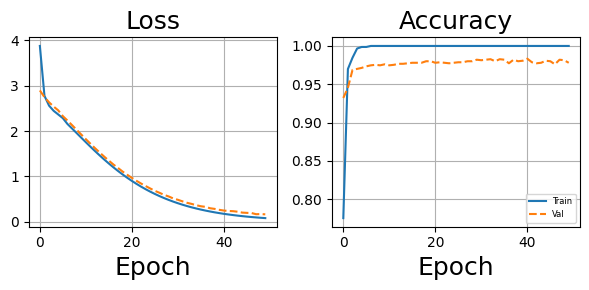

In [9]:
## Test Prediction Model
start = time.time()
Te_Pre = PreModel(Te, model)
end = time.time()
Te_Time = end - start
## Classification Report for Test Model
Te_classification,Te_Confusion,Te_OA,Te_Per_Class,Te_AA,Te_Kappa = ClassificationReports(TeC, HSID, Te_Pre, target_names)
print(Te_classification)
## Writing Results in CSV File
file_name = f"{HSID}_{teRatio}_{vrRatio}_{WS}_Classification_Report.csv"
CSV_file = CSVResults(file_name, Tr_Time, Te_Time, Te_classification,
                      Te_Confusion, Te_Kappa, Te_OA, Te_AA, Te_Per_Class)
files.download(file_name)
# Plot training and validation loss and accuracy for each model on one graph
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].plot(history.history['loss'], label='Train')
axs[0].plot(history.history['val_loss'], label='Val', linestyle='--')
# Plot accuracy
axs[1].plot(history.history['accuracy'], label='Train')
axs[1].plot(history.history['val_accuracy'], label='Val', linestyle='--')
# Add labels and legend
axs[0].set_title('Loss', fontsize=18)
axs[0].set_xlabel('Epoch', fontsize=18)
axs[1].set_title('Accuracy', fontsize=18)
axs[1].set_xlabel('Epoch', fontsize=18)
axs[1].legend(fontsize=6)
# Add grid lines and set background color
axs[0].grid(True)
axs[1].grid(True)
plt.tight_layout()
file_name = f"{HSID}_{teRatio}_{WS}_acc_loss_curve.png"
plt.savefig(file_name, dpi=500)
files.download(file_name)